# Thème 3: Aménagement cyclable/apaisement

**Analyse carto** : Identifier et caractériser le nombre d’avis citoyen faisant référence à un projet financé par l’Etat 

> Hypothèse : L’action financière de l’Etat en matière d’aménagement cyclable améliore la sécurité des cyclistes 

## Python stuff

In [4]:
import pandas as pd
import geopandas as gpd
# import plotly.express as px
from s3_utils import S3Manager
import matplotlib.pyplot as plt

_ = plt.style.use("ggplot")

In [5]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

## 1 - Récupération des données

In [6]:
# Import des données sources
gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")
gdf.head()

✅ Fichier chargé et converti en GeoDataFrame avec succès


,uid,cat,uid_reponse,description,geometry
0,dd441ba7-d3a7-490e-8cfe-1d34e4a09311,58,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Route trop étroite et dangereuse,POINT (4.47109 47.1244)
1,63ef8e40-8be8-4362-b9ea-5b38a0347ef3,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Maison de santé,POINT (4.48483 47.13117)
2,899273c7-bdec-4e6b-a7bb-f81dd8b2e2cf,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre social,POINT (4.49131 47.13086)
3,7818ede4-4bc5-4681-b603-d9799ee57ba9,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre ville,POINT (4.48614 47.13059)
4,384f138d-551f-48cb-a8e6-7545a3486eed,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,pas de piste cyclable ; stationnement de voitu...,POINT (3.07002 50.60544)


In [7]:
# Import des données d'enrichissements
amenagements_cyclables = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/externe/3.D. 2025___laur_ats_des_aap_fma__am_nagements_cyclables_.geojson")
print(amenagements_cyclables.shape)
amenagements_cyclables.head()

✅ Fichier chargé et converti en GeoDataFrame avec succès
(1178, 9)


,id,0,AAP,porteur,nom,description,region,,geometry
0,cwOTM,,1,Angers Loire Métropole,Réalisation d'une double passerelle dans la co...,Les objectifs du projet consistent à assurer l...,Pays de la Loire,,POINT (-0.57579 47.42817)
1,Q4OTE,,1,Clermont Auvergne Métropole,Projet d’aménagement de l’avenue Ernest Cristal,Dans le profil de la nouvelle voirie Ernest Cr...,Auvergne-Rhône-Alpes,,POINT (3.11555 45.78565)
2,Y1NDU,,1,Collectivité de Corse,Jonction de la liaison douce entre les quartie...,Création d’une voie verte reliant la voie vert...,Corse,,POINT (8.70132 41.93479)
3,E4NjM,,1,Communauté d'Agglomération de Longwy,Démarche responsable de continuité cyclable su...,Le projet faisant l'objet de la présente deman...,Grand Est,,POINT (5.76638 49.5214)
4,E5MDY,,1,Communauté d’Agglomération du Grand Montauban,Création d'une liaison cyclable Montauban – Br...,Dans le sens Montauban-Bressols : l’itinérair...,Occitanie,,POINT (1.33791 43.98996)


In [50]:
url_contour_france = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
contour_france = gpd.read_file(url_contour_france)

In [51]:
gdf = gdf.to_crs(contour_france.crs)
gdf_filtre = gpd.sjoin(gdf, contour_france, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])

In [17]:
amenagements_cyclables = amenagements_cyclables[[
    'id', 'AAP', 'porteur', 'nom', 'description', 'region','geometry'
]]

In [53]:
amenagements_cyclables = amenagements_cyclables.to_crs(contour_france.crs)
amenagements_cyclables_filtre = gpd.sjoin(amenagements_cyclables, contour_france, predicate="within", how="inner")
amenagements_cyclables_filtre = amenagements_cyclables_filtre.drop(columns=["index_right"])

## 2 - Nombre d'avis citoyen faisant référence à un projet financé par l'État

### 2.1 - Statistique globale

In [56]:
gdf_2154 = gdf_filtre.to_crs("2154").copy()
amenagements_cyclables_2154 = amenagements_cyclables_filtre.to_crs("2154").copy()
print(gdf_2154.crs == amenagements_cyclables_2154.crs)

True


In [81]:
avis_ref_fma = gpd.sjoin_nearest(
    gdf_2154,
    amenagements_cyclables_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="fma",
    distance_col="dist_m"
)

In [83]:
avis_ref_fma = avis_ref_fma[avis_ref_fma["cat"] == 60]
print(f"Nombre de points verts : {avis_ref_fma.shape[0]}")
print(f"Nombre de points verts avec un aménagement cyclable à moins de 50 m : {avis_ref_fma[avis_ref_fma['id'].notnull()].shape[0]}")
pct_points_couverts = 100 * avis_ref_fma[avis_ref_fma["id"].notnull()].shape[0] / avis_ref_fma.shape[0]
print(f"Pourcentage de points verts avec un aménagement cyclable à moins de 50 m : {pct_points_couverts:.2f}%")

Nombre de points verts : 239581
Nombre de points verts avec un aménagement cyclable à moins de 50 m : 1603
Pourcentage de points verts avec un aménagement cyclable à moins de 50 m : 0.67%


### 2.2 - Déclinaison par commune

In [89]:
# Récupération par communes
communes = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/communes.geojson")
communes = communes.to_crs(2154)

In [138]:
avis_ref_fma_communes = avis_ref_fma[avis_ref_fma['id'].notnull()][["geometry", "code_velo", "cat", "dist_m", "description_velo"]]
print(avis_ref_fma_communes.shape)
avis_ref_fma_communes.head()

(1603, 5)


,geometry,code_velo,cat,dist_m,description_velo
704,POINT (770105.516 6279773.95),34,60,28.446134,
3723,POINT (365248.374 6959361.984),50,60,24.205443,
4962,POINT (512719.063 6637300.031),86,60,35.977952,None
5253,POINT (659019.177 6862039.711),93,60,8.125585,top
5318,POINT (658978.189 6862058.907),93,60,40.055227,Pistes cyclables améliorées après travaux


In [139]:
avis_ref_fma_communes = avis_ref_fma_communes.sjoin(communes, predicate="within", how="inner").copy()
avis_ref_fma_communes.drop(columns=["code", "index_right"], inplace=True)
avis_ref_fma_communes = avis_ref_fma_communes.rename(columns={"nom": "commune"})
avis_ref_fma_communes.head()

,geometry,code_velo,cat,dist_m,description_velo,commune
704,POINT (770105.516 6279773.95),34,60,28.446134,,Montpellier
3723,POINT (365248.374 6959361.984),50,60,24.205443,,Cherbourg-en-Cotentin
4962,POINT (512719.063 6637300.031),86,60,35.977952,None,Châtellerault
5253,POINT (659019.177 6862039.711),93,60,8.125585,top,Montreuil
5318,POINT (658978.189 6862058.907),93,60,40.055227,Pistes cyclables améliorées après travaux,Montreuil


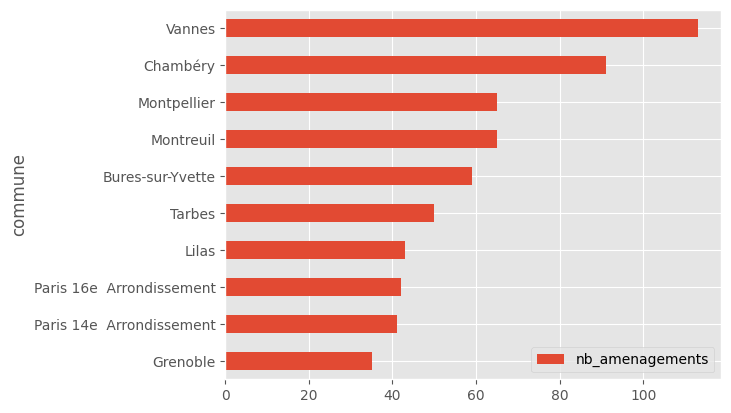

In [141]:
avis_communes = pd.pivot_table(
    avis_ref_fma_communes,
    index="commune",
    values="geometry",
    aggfunc="count"
).sort_values("geometry").reset_index().sort_values(by="geometry", ascending=False)
avis_communes.rename(columns={"geometry": "nb_amenagements"}, inplace=True)
_ = avis_communes.set_index("commune").head(10).sort_values(by="nb_amenagements", ascending=True).plot(kind="barh")

## 3 - Nombre d'aménagements cyclable faisant référence à un avis citoyen

### 3.1 - Statistique globale

In [68]:
fma_ref_avis = gpd.sjoin_nearest(
    amenagements_cyclables_2154,
    gdf_2154,
    how="left",
    max_distance=50,
    lsuffix="fma",
    rsuffix="velo",
    distance_col="dist_m"
)

In [ ]:
print(f"Nombre d'aménagements : {amenagements_cyclables_2154.shape[0]}")
print(f"Nombre d'aménagements à moins de 50 m des avis citoyens : {fma_ref_avis[fma_ref_avis['index_velo'].notnull()].shape[0]}")
pct_points_couverts = 100 * fma_ref_avis[fma_ref_avis["index_velo"].notnull()].shape[0] / amenagements_cyclables_2154.shape[0]
print(f"Pourcentage d'aménagements à moins de 50 m des avis citoyens : {pct_points_couverts:.2f}%")

Nombre d'aménagement : 1116
Nombre d'aménagement à moins de 50 m des avis citoyens : 187
Pourcentage de points verts avec un aménagement cyclable à moins de 50 m : 16.76%


### 3.2 - Déclinaison par commune

In [113]:
fma_ref_avis_communes = fma_ref_avis.reset_index()
fma_ref_avis_communes = fma_ref_avis_communes[fma_ref_avis_communes['index_velo'].notnull()][["geometry", "id", "description_fma", "porteur", "dist_m"]]
print(fma_ref_avis_communes.shape)
fma_ref_avis_communes.head()

(187, 5)


,geometry,id,description_fma,porteur,dist_m
0,POINT (402549.601 6896758.061),M1NTI,Le projet consiste en la réalisation d'un tunn...,Saint-Lô Agglomération,19.790770
1,POINT (823707.502 6964237.558),k3OTA,,Ville de Charleville-Mézières,42.385395
2,POINT (420432.354 6419425.807),c1NDA,Le Quai Wilson à Bègles est une voie à doubl...,Bordeaux Métropole,48.085874
3,POINT (678443.505 6858920.463),c3NTk,Création d'un franchissement cyclable du type ...,Communauté d'Agglomération de Marne et Gondoire,4.287430
4,POINT (385884.986 6408096.001),EyNDU,Création d'une liaison cyclable entre le résea...,Communauté d'Agglomération du Bassin d'Arcacho...,36.779220


In [114]:
fma_ref_avis_communes = fma_ref_avis_communes.sjoin(communes, predicate="within", how="inner")
fma_ref_avis_communes.drop(columns=["code", "index_right"], inplace=True)
fma_ref_avis_communes = fma_ref_avis_communes.rename(columns={"nom": "commune"})
fma_ref_avis_communes.head()

,geometry,id,description_fma,porteur,dist_m,commune
0,POINT (402549.601 6896758.061),M1NTI,Le projet consiste en la réalisation d'un tunn...,Saint-Lô Agglomération,19.790770,Saint-Lô
1,POINT (823707.502 6964237.558),k3OTA,,Ville de Charleville-Mézières,42.385395,Charleville-Mézières
2,POINT (420432.354 6419425.807),c1NDA,Le Quai Wilson à Bègles est une voie à doubl...,Bordeaux Métropole,48.085874,Bègles
3,POINT (678443.505 6858920.463),c3NTk,Création d'un franchissement cyclable du type ...,Communauté d'Agglomération de Marne et Gondoire,4.287430,Bussy-Saint-Georges
4,POINT (385884.986 6408096.001),EyNDU,Création d'une liaison cyclable entre le résea...,Communauté d'Agglomération du Bassin d'Arcacho...,36.779220,Audenge


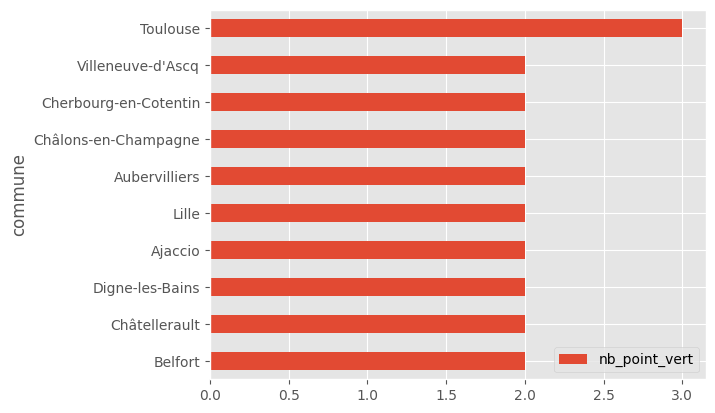

In [ ]:
fma_communes = pd.pivot_table(
    fma_ref_avis_communes,
    index="commune",
    values="id",
    aggfunc="count"
).sort_values("id").reset_index().sort_values(by="id", ascending=False)
fma_communes.rename(columns={"id": "nb_point_vert"}, inplace=True)
_ = fma_communes.set_index("commune").head(10).sort_values(by="nb_point_vert", ascending=True).plot(kind="barh")